# Predicting car market price with KNN

We are tasked with predicting what certain cars will be sold for on the market, depending on their attributes. The dataset is taken from the UCI Machine Learning Repository [here](https://archive.ics.uci.edu/ml/datasets/automobile).


# Cleaning

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
col_names = ['symboling','normalized_losses','make','fuel_type','aspiration',
             'num_of_doors','body_style','drive_wheels','engine_location',
             'wheel_base','length','width','height','curb_weight',
             'engine_type','num_cyl','engine_size','fuel_system','bore',
             'stroke','compression_ratio','horsepower','peak_rpm',
             'city_mpg','highway_mpg','price']

In [3]:
cars = pd.read_csv('imports-85.data', header=None)
cars.columns = col_names

In [4]:
cars.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [5]:
cars = cars.replace('?',np.nan)

In [6]:
cars = cars.astype({
    'normalized_losses':float,
    'bore':float,
    'stroke':float,
    'horsepower':float,
    'peak_rpm':float,
    'price':float
})

KNN algorithms can only use continuous variables with all observations having a value, so we start by filtering selecting only the appropriate columns. According to the data dictionary the following columns are continuous:

* `normalized_losses`
* `wheel_base`
* `length`
* `width`
* `height`
* `curb_weight`
* `engine_size`
* `bore`
* `stroke`
* `compression-ratio`
* `horsepower`
* `peak_rpm`
* `city_mpg`
* `highway_mpg`
* `price`

In [78]:
num_cars = cars[['make','normalized_losses','wheel_base',
                 'length','width','height','curb_weight',
                 'engine_size','bore','stroke','compression_ratio','horsepower',
                 'peak_rpm','city_mpg','highway_mpg','price']].copy()

## Nan values

In [79]:
num_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203 entries, 0 to 204
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               203 non-null    object 
 1   normalized_losses  162 non-null    float64
 2   wheel_base         203 non-null    float64
 3   length             203 non-null    float64
 4   width              203 non-null    float64
 5   height             203 non-null    float64
 6   curb_weight        203 non-null    int64  
 7   engine_size        203 non-null    int64  
 8   bore               199 non-null    float64
 9   stroke             199 non-null    float64
 10  compression_ratio  203 non-null    float64
 11  horsepower         201 non-null    float64
 12  peak_rpm           201 non-null    float64
 13  city_mpg           203 non-null    int64  
 14  highway_mpg        203 non-null    int64  
 15  price              199 non-null    float64
dtypes: float64(11), int64(4), 

The following columns contain missing values:

* `normalized_losses`
* `bore`
* `stroke`
* `horsepower`
* `peak_rpm`
* `price`

### price

All four cars without a price are also missing the `normalized_losses` variable. We cannot have NaN as a `price` for our model. We have two choices:

* Remove these four rows
* Replace the NaN with the average of the prices

In [80]:
nan_price.groupby('make')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
make,,,,,,,,
audi,6.0,17859.166667,3452.379493,13950.0,15800.00,17580.0,18617.50,23875.0
isuzu,2.0,8916.500000,3014.396208,6785.0,7850.75,8916.5,9982.25,11048.0
porsche,4.0,31400.500000,6528.784343,22018.0,29900.50,33278.0,34778.00,37028.0


Since the price depends on as of yet unknown features, we will remove the four rows to avoid biasing the model when predicting prices for these three makes.

In [81]:
num_cars = num_cars.dropna(subset=['price'],axis = 0)

In [82]:
num_cars['price'].isna().sum()

0

### normalized_losses

The `normalized_losses` feature has the most `nan` values and is worth investigating.

In [83]:
num_cars['normalized_losses'].isna().sum()

37

In [85]:
# count the number of cars per maker
car_count = pd.DataFrame(num_cars.groupby('make').count()['length']).reset_index()
car_count.columns=['make','obs_num']

In [87]:
# count the number of nan values per maker
na_norm_losses_count = pd.DataFrame(num_cars[num_cars['normalized_losses'].isna()]['make'].value_counts()).reset_index()
na_norm_losses_count.columns = ['make','nan_num']

In [88]:
# merge the two datasets and calculate the difference
compare = car_count.merge(na_norm_losses_count)
compare['no_nan'] = compare['obs_num'] - compare['nan_num']
compare['perc_nan'] = round((compare['nan_num']/compare['obs_num'])*100,2)

In [89]:
compare.sort_values('perc_nan', ascending=False)

,make,obs_num,nan_num,no_nan,perc_nan
0,alfa-romero,3,3,0,100.00
3,isuzu,2,2,0,100.00
7,mercury,1,1,0,100.00
12,renault,2,2,0,100.00
11,porsche,4,3,1,75.00
4,jaguar,3,2,1,66.67
2,bmw,8,4,4,50.00
1,audi,5,2,3,40.00
6,mercedes-benz,8,3,5,37.50
9,peugot,11,4,7,36.36


37 of the `normalized_losses` values are `NaN`. To fix this we will do the following:

* Car makes who's `normalized_losses` are always `NaN` are removed. These makes coincidentally do not have many data to begin with (such as price), so not much is lost.
    * `alfa-romero`
    * `isuzu`
    * `mercury`
    * `renault`
* Car makes who have some numbers for `normalized_losses` will be kept, and the `NaN` replaced with the average.

According to the data dictionary the `normalized_losses` variable represents "average loss payment per insured vehicle year". It depends on various size classifications of the car, such as number of doors, sedan vs hatchback, and so on. We assume the following describes the vehicle's size:

* `num_of_doors`
* `body_style`
* `length`
* `width`
* `height`
* `curb_weight`
* `engine_size`

Of these variables `num_of_doors` and`body_style` are not continuous variables and so are not considered.

In [104]:
norm_loss_cols = ['make','normalized_losses',
                   'length', 'width', 'height', 'curb_weight',
                   'engine_size', 'price']

norm_loss_df = num_cars[norm_loss_cols][num_cars[norm_loss_cols]['normalized_losses'].isna()]
norm_loss_df.head()

,make,normalized_losses,length,width,height,curb_weight,engine_size,price
0,alfa-romero,NaN,168.8,64.1,48.8,2548,130,13495.0
1,alfa-romero,NaN,168.8,64.1,48.8,2548,130,16500.0
2,alfa-romero,NaN,171.2,65.5,52.4,2823,152,16500.0
5,audi,NaN,177.3,66.3,53.1,2507,136,15250.0
7,audi,NaN,192.7,71.4,55.7,2954,136,18920.0


In [105]:
norm_loss_df = norm_loss_df.melt(id_vars = ['make','price','normalized_losses'])
norm_loss_df.head()

,make,price,normalized_losses,variable,value
0,alfa-romero,13495.0,NaN,length,168.8
1,alfa-romero,16500.0,NaN,length,168.8
2,alfa-romero,16500.0,NaN,length,171.2
3,audi,15250.0,NaN,length,177.3
4,audi,18920.0,NaN,length,192.7


<AxesSubplot:xlabel='variable', ylabel='value'>

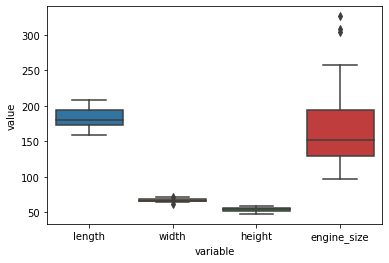

In [113]:
sns.boxplot(x='variable',y = 'value', data= norm_loss_df[norm_loss_df['variable'] != 'curb_weight'])

There are not too many outliers in these variables, so we will take the mean to fill the `nan`.

In [120]:
# figure out the mean of each make's normalized_losses
norm_loss_means = num_cars.groupby('make').mean()['normalized_losses'].reset_index()
norm_loss_means.head()

,make,normalized_losses
0,alfa-romero,121.580247
1,audi,145.832099
2,bmw,155.790123
3,chevrolet,100.000000
4,dodge,133.444444


In [121]:
# identify each nan, replace it with the mean of that maker's normalized_losses
for i, row in num_cars.iterrows():
    if np.isnan(row['normalized_losses']):
        make_mean = norm_loss_means.loc[row['make']][0]
        num_cars.loc[i,'normalized_losses'] = make_mean

### bore and stroke

In [124]:
num_cars[num_cars['bore'].isna()]

,make,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
51,mazda,150.0,95.3,169.0,65.7,49.6,2380,70,NaN,NaN,9.4,101.0,6000.0,17,23,10945.0
52,mazda,150.0,95.3,169.0,65.7,49.6,2380,70,NaN,NaN,9.4,101.0,6000.0,17,23,11845.0
53,mazda,150.0,95.3,169.0,65.7,49.6,2385,70,NaN,NaN,9.4,101.0,6000.0,17,23,13645.0
54,mazda,150.0,95.3,169.0,65.7,49.6,2500,80,NaN,NaN,9.4,135.0,6000.0,16,23,15645.0


All the `nan` values for `bore` and `stroke` are under the `mazda` make, with a `hatchback` body style. 

We should avoid removing any more observations as the dataset is limited. We can note that `bore` and `stroke` are based on the type of the engine, and categorize the power it can make. As we have other variables to describe the engine (`engine_type`, `engine_size`) and the bore/stroke descriptions are summarized by the `compression_ratio`, we will remove these features.

In [126]:
num_cars = num_cars.drop(['bore','stroke'],axis=1)

In [127]:
num_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               199 non-null    object 
 1   normalized_losses  199 non-null    float64
 2   wheel_base         199 non-null    float64
 3   length             199 non-null    float64
 4   width              199 non-null    float64
 5   height             199 non-null    float64
 6   curb_weight        199 non-null    int64  
 7   engine_size        199 non-null    int64  
 8   compression_ratio  199 non-null    float64
 9   horsepower         197 non-null    float64
 10  peak_rpm           197 non-null    float64
 11  city_mpg           199 non-null    int64  
 12  highway_mpg        199 non-null    int64  
 13  price              199 non-null    float64
dtypes: float64(9), int64(4), object(1)
memory usage: 21.9+ KB


### horsepower and peak_rpm

In [128]:
num_cars[num_cars['horsepower'].isna()]

,make,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
124,renault,121.580247,96.1,181.5,66.5,55.2,2579,132,8.7,NaN,NaN,23,31,9295.0
125,renault,121.580247,96.1,176.8,66.6,50.5,2460,132,8.7,NaN,NaN,23,31,9895.0


The two `nan` in these variables belong to the same make, and to observations with very similar characteristics

In [129]:
num_cars[num_cars['make']=='renault']

,make,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
124,renault,121.580247,96.1,181.5,66.5,55.2,2579,132,8.7,NaN,NaN,23,31,9295.0
125,renault,121.580247,96.1,176.8,66.6,50.5,2460,132,8.7,NaN,NaN,23,31,9895.0


These two cars also happen to be the only `renault` observations, and the `normalized_losses` was estimated. 

In [133]:
renault_similars = num_cars[(num_cars['price']<10000) & (num_cars['price'] > 9000) & 
                            (num_cars['compression_ratio'] > 8) & (num_cars['compression_ratio'] < 9)]
renault_similars

,make,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
96,nissan,106.000000,97.2,173.4,65.2,54.7,2302,120,8.5,97.0,5200.0,27,34,9549.0
124,renault,121.580247,96.1,181.5,66.5,55.2,2579,132,8.7,NaN,NaN,23,31,9295.0
125,renault,121.580247,96.1,176.8,66.6,50.5,2460,132,8.7,NaN,NaN,23,31,9895.0
169,toyota,65.000000,102.4,175.6,66.5,53.9,2414,122,8.7,92.0,4200.0,27,32,9988.0
184,volkswagen,256.000000,94.5,165.7,64.0,51.4,2221,109,8.5,90.0,5500.0,24,29,9980.0


The two renaults have very similar characteristics (of continuous variables at least) to 3 other cars. We will take the mean `horsepower` and `peak_rpm` of these 3 cars and use it for the renault.

In [138]:
mean_horse = renault_similars[['horsepower','peak_rpm']].mean()[0]
mean_rpm = renault_similars[['horsepower','peak_rpm']].mean()[1]

In [139]:
for i in [124,125]:
    num_cars.loc[i,'horsepower'] = mean_horse
    num_cars.loc[i,'peak_rpm'] = mean_rpm

In [141]:
num_cars.isna().sum()

make                 0
normalized_losses    0
wheel_base           0
length               0
width                0
height               0
curb_weight          0
engine_size          0
compression_ratio    0
horsepower           0
peak_rpm             0
city_mpg             0
highway_mpg          0
price                0
dtype: int64

We have no more `nan` to take care of!

## Normalization

In order to properly compare across numeric features, we will normalize the values using min-max normalization:

`(x - min(x))/(max(x) - min(x))`

In [142]:
norm_cars = num_cars.copy()

In [145]:
norm_cols = list(norm_cars.columns)
norm_cols.remove('price')
norm_cols.remove('make')

In [146]:
# normalize everything except the price (and the make)
for col in norm_cols:
    norm_cars[col] = (norm_cars[col]-norm_cars[col].min())/(norm_cars[col].max()-norm_cars[col].min())

In [149]:
norm_cars.head()

,make,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,alfa-romero,0.296232,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,alfa-romero,0.296232,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,alfa-romero,0.296232,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,audi,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,audi,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


# Univariate Model Building

In our first journey in machine learning, we will build several univariate KNN models to see which single feature best predicts the target (`price`).

In [152]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [154]:
def uni_knn_train_test(train_col, targ_col, df, k = 5):
    '''
    Trains and validates using KNN to predict the targ_col
    from the train_col.
    
    input
    -----
    train_col: str
    targ_col: str
    df: pd.DataFrame
    k: int
    '''
    # define feature and target
    np.random.seed(1)
    feature = [train_col]
    target = targ_col
    
    # shuffle the order of dataset
    shuffled = df.loc[np.random.permutation(df.index)].copy()
    shuffled = shuffled.reindex()
    
    # divide the dataset into train and test dataframes
    eighty = round(len(shuffled) * 0.8)
    train_df = shuffled.loc[:eighty,:]
    test_df = shuffled.loc[eighty:,:]
    
    # initiate and fit our model to the dataset
    knn = KNeighborsRegressor(n_neighbors = k, algorithm = 'brute')
    knn.fit(train_df[feature],train_df[target])
    
    # predict using our KNN algorithm
    prediction = knn.predict(test_df[feature])
    
    # calculate the evaluating statistic (root mean squared error)
    mse = mean_squared_error(test_df[target],prediction)
    rmse = np.sqrt(mse)
    
    return rmse

In [155]:
# get the rmse for each feature
rmse_dic = {}

for col in norm_cols:
    rmse_dic[col] = uni_knn_train_test(col,'price',norm_cars)

In [156]:
k_5_uni_knn = pd.Series(rmse_dic).sort_values()
k_5_uni_knn

highway_mpg          3029.050652
engine_size          3092.109408
width                3348.918814
city_mpg             3558.993038
curb_weight          3802.916492
length               4493.283985
wheel_base           4685.907910
horsepower           4784.772541
compression_ratio    5853.012447
peak_rpm             5923.633704
height               6421.197869
normalized_losses    6911.006492
dtype: float64

Based on our simple univariate KNN model (using k=5) so far, `highway_mpg` and `engine_size` were best able to predict the `price` of a car.

We will next figure out whether the hyperparameter can be tweeked for more accurate results.

In [158]:
rmse_dic_multi = {}

In [159]:
# get the rmse for each column, at different k neighbor values
for col in norm_cols:
    col_k = {}
    for k in [1,3,5,7,9]:
        rmse = uni_knn_train_test(col,'price',norm_cars,k=k)
        col_k[k] = rmse
    rmse_dic_multi[col] = col_k

In [167]:
uni_multi_k = pd.DataFrame(rmse_dic_multi).reset_index()
uni_multi_k.columns = ['k_value', 'normalized_losses', 'wheel_base', 'length', 'width', 'height',
       'curb_weight', 'engine_size', 'compression_ratio', 'horsepower',
       'peak_rpm', 'city_mpg', 'highway_mpg']
uni_multi_k.head()

,k_value,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
0,1,6243.864985,4334.276978,5238.062660,5332.354040,9018.092629,4196.685175,3924.052442,6239.163744,4470.663889,5898.349741,3966.486178,4286.561838
1,3,6240.006828,4830.422815,4899.639573,3373.204697,6324.625123,3960.088412,2939.118540,5453.220645,4250.887712,5733.261644,3302.613487,3116.866472
2,5,6911.006492,4685.907910,4493.283985,3348.918814,6421.197869,3802.916492,3092.109408,5853.012447,4784.772541,5923.633704,3558.993038,3029.050652
3,7,7085.640198,5252.867311,4907.508224,3167.417387,6548.817859,3242.371768,3255.035412,5912.638224,4375.232735,5962.288809,3564.828721,3035.409607
4,9,6797.648428,5371.908643,4991.625750,3299.468896,6765.064646,3191.138605,3224.079703,6470.839073,4190.211331,6437.544777,3690.596702,3346.980264


The dataset above gives the root mean squared error for each feature, at different k neighbor hyperparameters. It's hard to visualize which `k_value` setting did best in the KNN algorithm, so let's plot it and see what we get.

In [168]:
uni_multi_k = uni_multi_k.melt(id_vars = 'k_value')
uni_multi_k.columns = ['k_value','feature','rmse']
uni_multi_k.head()

,k_value,feature,rmse
0,1,normalized_losses,6243.864985
1,3,normalized_losses,6240.006828
2,5,normalized_losses,6911.006492
3,7,normalized_losses,7085.640198
4,9,normalized_losses,6797.648428


Text(0.5, 1.0, 'Root mean squared error by feature and hyperparameter')

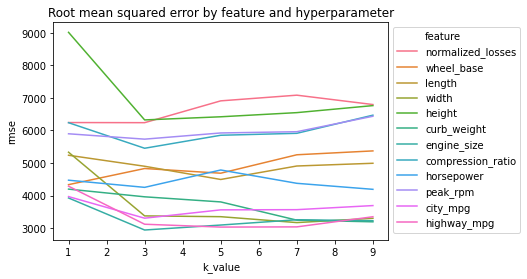

In [169]:
sns.lineplot(x = 'k_value',y='rmse',hue='feature',data=uni_multi_k)
plt.legend(bbox_to_anchor = (1,1))
plt.title('Root mean squared error by feature and hyperparameter')

In [171]:
uni_multi_k.sort_values('rmse').head()

,k_value,feature,rmse
31,3,engine_size,2939.118540
57,5,highway_mpg,3029.050652
58,7,highway_mpg,3035.409607
32,5,engine_size,3092.109408
56,3,highway_mpg,3116.866472


Overall, each feature has an optimal `k_value`. The `rmse` decreases as k increases, but will increase again after a certain point. 

The lowest `rmse`s are from `engine_size` and `highway_mpg` at `k_value`s of 3 and 5 respectively.

We will try a multivariate KNN model next to see if the `rmse` can be lowered further.

# Multivariate Model Building

In order to use a multivariate model we first need to have some idea of what features would best predict the `price`.

In [176]:
def multi_knn_train_test(train_list, targ_col, df, k = 5):
    '''
    Trains and validates using KNN to predict the targ_col
    from the train_col.
    
    input
    -----
    train_col: str
    targ_col: str
    df: pd.DataFrame
    k: int
    '''
    # define feature and target
    np.random.seed(1)
    feature = train_list
    target = targ_col
    
    # shuffle the order of dataset
    shuffled = df.loc[np.random.permutation(df.index)].copy()
    shuffled = shuffled.reindex()
    
    # divide the dataset into train and test dataframes
    eighty = round(len(shuffled) * 0.8)
    train_df = shuffled.loc[:eighty,:]
    test_df = shuffled.loc[eighty:,:]
    
    # initiate and fit our model to the dataset
    knn = KNeighborsRegressor(n_neighbors = k, algorithm = 'brute')
    knn.fit(train_df[feature],train_df[target])
    
    # predict using our KNN algorithm
    prediction = knn.predict(test_df[feature])
    
    # calculate the evaluating statistic (root mean squared error)
    mse = mean_squared_error(test_df[target],prediction)
    rmse = np.sqrt(mse)
    
    return rmse

In [173]:
best_df = k_5_uni_knn.reset_index()
best_df

,index,0
0,highway_mpg,3029.050652
1,engine_size,3092.109408
2,width,3348.918814
3,city_mpg,3558.993038
4,curb_weight,3802.916492
5,length,4493.283985
6,wheel_base,4685.907910
7,horsepower,4784.772541
8,compression_ratio,5853.012447
9,peak_rpm,5923.633704


According to our univariate modeling above, the top five 'best' features (using a default `k_value` of 5) for the task are:

* `highway_mpg`
* `engine_size`
* `width`
* `city_mpg`
* `curb_weight`

In [178]:
multi_dic = {}
# Using all features for comparison
all_rmse = multi_knn_train_test(best_df['index'], 
                                        'price',norm_cars)
multi_dic[12] = [all_rmse]

In [179]:
# Using best X from the univariate model

for x in [2,3,4,5]:
    rmse = multi_knn_train_test(list(best_df['index'][0:x]), 
                                'price',norm_cars)
    multi_dic[x] = [rmse]

In [184]:
multi_k_five = pd.DataFrame(multi_dic).T.sort_values(0).reset_index()
multi_k_five.columns = ['top_x_features','rmse']
multi_k_five.sort_values('rmse')

,top_x_features,rmse
0,3,2505.396792
1,4,2508.056958
2,5,2671.228941
3,2,2804.676028
4,12,2971.671980


Text(0, 0.5, 'RMSE')

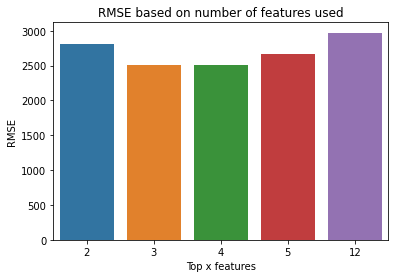

In [186]:
sns.barplot(x='top_x_features',y='rmse',data=multi_k_five)
plt.title('RMSE based on number of features used')
plt.xlabel("Top x features")
plt.ylabel('RMSE')

According to our multivariate model (with k neighbors of 5) the best `price` prediction we could get is with either 3 or 4 of the top univariate features. Using only 2 or as much as 5 features resulted in larger mean errors, and using all features did worse of all.

# Hyperparameter Optimization

While we have an idea of which features to use, the question now is how wide to cast our net? How many k neighbors would be the most accurate way to predict the `price` of cars on the market?

In [188]:
hyper_k_rmse_dic = {}

# Run multivariate KNN using the top x features, as determined when k=5 was assumed.
for x in [3,4,5]:
    temp_dic = {}
    # test with k values 1-25
    for k in range(1,26):
        features = list(best_df['index'][0:x])
        rmse = multi_knn_train_test(features,
                                    'price',norm_cars, k=k)
        temp_dic[k] = rmse
    hyper_k_rmse_dic["{0}_best_features".format(x)] = temp_dic

In [200]:
multiv_multi_k = pd.DataFrame(hyper_k_rmse_dic).reset_index()
multiv_multi_k.columns = ['k_value','3_best_features','4_best_features','5_best_features']
multiv_multi_k.head()

,k_value,3_best_features,4_best_features,5_best_features
0,1,1960.524463,1948.212421,2200.681052
1,2,1971.963128,2075.335704,2282.580271
2,3,2182.582965,2311.360363,2203.715255
3,4,2274.525564,2428.002917,2455.627547
4,5,2505.396792,2508.056958,2671.228941


With `k_value`s ranging from 1 through 25, it is very difficult to determine the most optimal hyperparameter settings. We will graph the above table.

In [ ]:
multiv_multi_k = multiv_multi_k.melt(id_vars = 'k_value')
multiv_multi_k.columns = ['k_value','top_features','rmse']

In [204]:
multiv_multi_k.sort_values('rmse').head(10)

,k_value,top_features,rmse
25,1,4_best_features,1948.212421
0,1,3_best_features,1960.524463
1,2,3_best_features,1971.963128
26,2,4_best_features,2075.335704
2,3,3_best_features,2182.582965
50,1,5_best_features,2200.681052
52,3,5_best_features,2203.715255
3,4,3_best_features,2274.525564
51,2,5_best_features,2282.580271
27,3,4_best_features,2311.360363


Text(0.5, 1.0, 'Root mean squared error by number of multivariate features and hyperparameter')

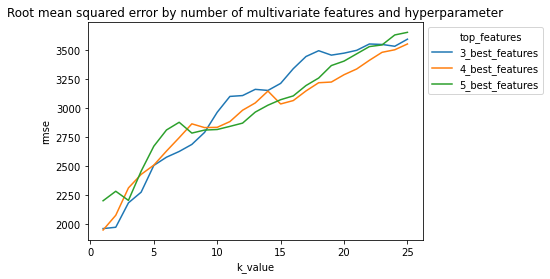

In [202]:
sns.lineplot(x = 'k_value',y='rmse',hue='top_features',data=multiv_multi_k)
plt.legend(bbox_to_anchor = (1,1))
plt.title('Root mean squared error by number of multivariate features and hyperparameter')

Each of the previously found models have `k_value`=1 as their optimal hyperparameters. 

* By using the top 4 features from our univariate model, and a `k_value`=1, we brought the `rmse` down to 1948.
* By using the top 3 features from our univariate model, and a `k_value`=1, we brought the `rmse` down to 1960.
* By using the top 5 features from our univariate model, and a `k_value`=1, we brought the `rmse` down to 2200.

# Conclusion

The most accurate model we built with this dataset was a multivate KNN model:

* `k_value` of 1
* `algorithm` as "brute"
* Using these features:
    * `highway_mpg`
    * `engine_size`
    * `width`
    * `city_mpg`
    
Individually these features were only able to predice the `price` with an `rmse` of around 3000-3500. Together, however, the final `rmse` value was decreased by 40% to just 1948.

Based on our analysis the car market value is best predicted with those four variables.

# From Dataquest

That's it for the guided steps. Here are some ideas for next steps:

* Modify the `knn_train_test()` function to use k-fold cross validation instead of test/train validation.
* Modify the `knn_train_test()` function to perform the data cleaning as well.


# K-fold cross validation

## Holdout validation

In [214]:
def knn_hold(train_list, targ_col, df, k = 5):
    '''
    Trains and validates using KNN to predict the targ_col
    from the train_col.
    
    input
    -----
    train_col: list
    targ_col: str
    df: pd.DataFrame
    k: int
    '''
    ## setup ##
    # define feature and target
    np.random.seed(1)
    feature = train_list
    target = targ_col
    
    # shuffle the order of dataset
    shuffled = df.loc[np.random.permutation(df.index)]
    shuffled = shuffled.reindex()
    
    # divide the dataset into train and test dataframes
    fifty = round(len(shuffled) * 0.5)
    split_one = shuffled.loc[:fifty,:].copy()
    split_two = shuffled.loc[fifty:,:].copy()
    
    ## split_one ##
    train_one = split_one
    test_one = split_two
    # initiate and fit our model
    knn = KNeighborsRegressor(n_neighbors = k, algorithm = 'brute')
    knn.fit(train_one[feature],train_one[target])
    # predict using the model
    predict_one = knn.predict(test_one[feature])
    mse_one = mean_squared_error(test_one[target],predict_one)
    rmse_one = np.sqrt(mse_one)
    
    ## split_two ##
    train_two = split_two
    test_two = split_one
    # initiate and fit our model
    knn = KNeighborsRegressor(n_neighbors = k, algorithm = 'brute')
    knn.fit(train_two[feature],train_two[target])
    # predict using the model
    predict_two = knn.predict(test_two[feature])
    mse_two = mean_squared_error(test_two[target],predict_two)
    rmse_two = np.sqrt(mse_two)
    
    avg_rmse = (rmse_one + rmse_two)/2
    return avg_rmse

In [218]:
# find the univariate rmse using holdout validation
uni_rmse_hold = {}
for col in norm_cols:
    rmse = knn_hold([col], 'price', norm_cars)
    uni_rmse_hold[col] = [rmse]

In [225]:
uni_rmse_hold = pd.DataFrame(rmse_hold).T.reset_index()
uni_rmse_hold.columns = ['feature','rmse']
uni_rmse_hold = uni_rmse_hold.sort_values('rmse').reset_index(drop=True)
uni_rmse_hold.head()

,feature,rmse
0,engine_size,3453.026762
1,highway_mpg,4137.692438
2,width,4140.871461
3,curb_weight,4185.776040
4,city_mpg,4221.084797


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'engine_size'),
  Text(1, 0, 'highway_mpg'),
  Text(2, 0, 'width'),
  Text(3, 0, 'curb_weight'),
  Text(4, 0, 'city_mpg'),
  Text(5, 0, 'horsepower'),
  Text(6, 0, 'length'),
  Text(7, 0, 'wheel_base'),
  Text(8, 0, 'compression_ratio'),
  Text(9, 0, 'peak_rpm'),
  Text(10, 0, 'height'),
  Text(11, 0, 'normalized_losses')])

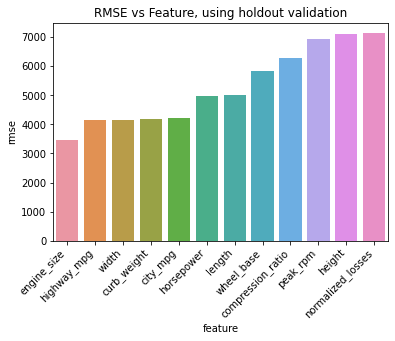

In [230]:
sns.barplot(x='feature',y='rmse',data=uni_rmse_hold)
plt.title('RMSE vs Feature, using holdout validation')
plt.xticks(rotation=45, horizontalalignment='right')

Univariate KNN with holdout variation resulted in the following top five features:

* `engine_size`
* `highway_mpg`
* `width`
* `curb_weight`
* `city_mpg`

In [239]:
# Using best X from the univariate model
multi_hold = {}
for x in [2,3,4,5]:
    feature = list(uni_rmse_hold['feature'][0:x])
    rmse = knn_hold(feature,'price',norm_cars)
    multi_hold[x] = [rmse]
    
multi_hold[12] = knn_hold(uni_rmse_hold['feature'],'price',norm_cars)

In [240]:
multi_hold = pd.DataFrame(multi_hold).T.reset_index()
multi_hold.columns = ['top_x_features','rmse']
multi_hold = multi_hold.sort_values('rmse').reset_index(drop=True)
multi_hold.head()

,top_x_features,rmse
0,5,3230.250616
1,3,3274.977805
2,4,3276.533136
3,2,3470.779137
4,12,3803.417477


Text(0.5, 1.0, 'RMSE vs Top X Features, using holdout validation')

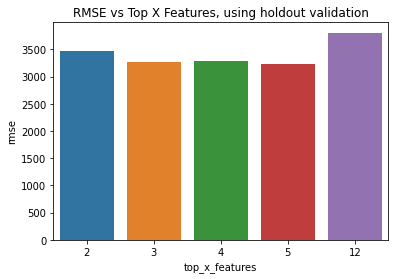

In [242]:
sns.barplot(x='top_x_features',y='rmse',data=multi_hold)
plt.title('RMSE vs Top X Features, using holdout validation')

Each multivariate KNN performed similarly with `k_value`=5 as calculated by holdout validation, except when using all 12 features.

In [265]:
# Lets tune the hyperparameters for KNN holdout variation
top_k_hold = {}
for x in [3,4,5]:
    k_dic = {}
    for k in range(1,26):
        feature = list(uni_rmse_hold['feature'][0:x])
        rmse = knn_hold(feature,'price',norm_cars,k=k)
        k_dic[k] = rmse
    top_k_hold[f'top_{x}_features'] = k_dic

In [ ]:
top_k_hold = pd.DataFrame(top_k_hold)
top_k_hold = top_k_hold.reset_index()
top_k_hold.columns = ['k_value','top_3_features','top_4_features','top_5_features']
top_k_hold = top_k_hold.melt(id_vars = 'k_value')

In [269]:
top_k_hold.sort_values('value').head()

,k_value,variable,value
25,1,top_4_features,2872.469369
50,1,top_5_features,2957.370401
1,2,top_3_features,2964.804609
26,2,top_4_features,2965.461311
0,1,top_3_features,2976.061494


<AxesSubplot:xlabel='k_value', ylabel='value'>

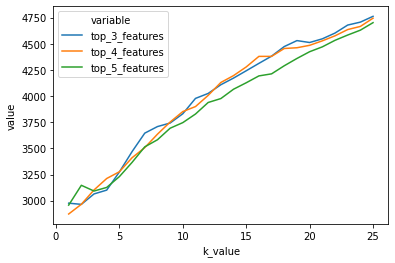

In [268]:
sns.lineplot(x = 'k_value', y='value', hue='variable', data=top_k_hold)

Very similar results as with the train/test validation. Using the`top_4_features` with `k_value`=1 resulted in the smallest `rmse` for the dataset.

# k-fold validation

Using both manual folds and the `KFold` and `cross_val_score` functions from the `sklearn.model_selection` library.

In [270]:
def knn_fold(train_list, targ_col, df, k = 5):
    '''
    Trains and validates using KNN to predict the targ_col
    from the train_col.
    
    input
    -----
    train_col: str
    targ_col: str
    df: pd.DataFrame
    k: int
    '''
    # define feature and target
    np.random.seed(1)
    feature = train_list
    target = targ_col
    
    # shuffle the order of dataset
    shuffled = df.loc[np.random.permutation(df.index)].copy()
    shuffled = shuffled.reindex()
    
    # divide the dataset into train and test dataframes
    eighty = round(len(shuffled) * 0.8)
    train_df = shuffled.loc[:eighty,:]
    test_df = shuffled.loc[eighty:,:]
    
    # initiate and fit our model to the dataset
    knn = KNeighborsRegressor(n_neighbors = k, algorithm = 'brute')
    knn.fit(train_df[feature],train_df[target])
    
    # predict using our KNN algorithm
    prediction = knn.predict(test_df[feature])
    
    # calculate the evaluating statistic (root mean squared error)
    mse = mean_squared_error(test_df[target],prediction)
    rmse = np.sqrt(mse)
    
    return rmse